"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
from scipy.stats import beta

In [2]:
# Some poisson spiking
length = 100
states = 3
trials = 30
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random((trials,states)),axis=-1)
print(true_tau.shape)
true_tau /= np.max(true_tau,axis=-1)[:,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)


state_inds = np.concatenate([np.zeros((trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

n_components = 2
true_lambda = np.random.random((n_components,states))

print(true_tau.shape)
print(state_inds.shape)
print(true_lambda.shape)



(30, 3)
(29, 3)
(30, 4)
(2, 3)


(30, 100)


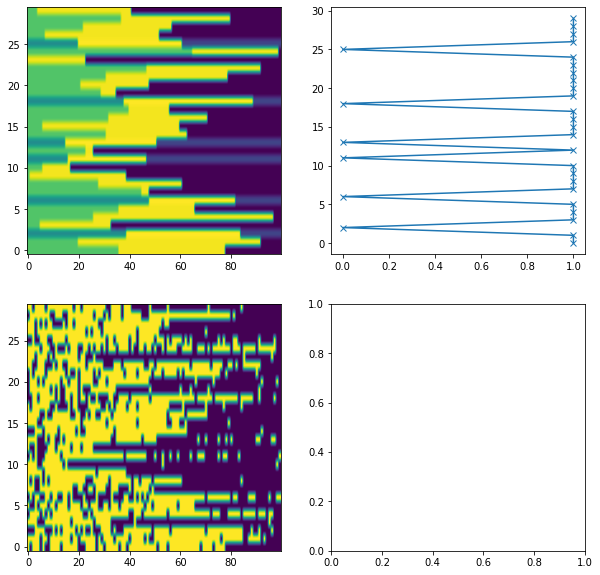

In [3]:
component_inds = np.random.choice(range(n_components), trials, p = [0.3,0.7])
true_r = np.zeros((trials,length))
for trial in range(trials):
    for state in range(states):
        true_r[trial, state_inds[trial,state]:state_inds[trial,state+1]] = \
                    true_lambda[component_inds[trial],state]
  
data_vec = np.random.random(true_r.shape) < true_r
print(data_vec.shape)
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,1].plot(component_inds, np.arange(trials),'-x')
ax[0,0].imshow(true_r,aspect='auto',origin='lower')
ax[1,0].imshow(data_vec,aspect='auto',origin='lower')
# ax[1].set_ylabel("True Rate")
# ax[2].set_ylabel("Spikes")

In [4]:
mean_vals = np.array([np.mean(x,axis=(0,-1)) for x in np.array_split(data_vec,states,axis=-1)]).T
print(mean_vals)

[0.69901961 0.56767677 0.23434343]


In [5]:
with pm.Model() as model:
    w = pm.Dirichlet('w', a=np.ones(n_components)*5, shape = n_components)
    category = pm.Categorical("category", p=w, shape=trials)
    alphas = pm.HalfCauchy('alphas',5,shape=(2,3))
    betas = pm.HalfCauchy('betas',5,shape=(2,3))
    clust0_lambda = tt.stack([pm.Beta('l00',alphas[0,0], betas[0,0]),
                             pm.Beta('l01',alphas[0,1], betas[0,1]),
                             pm.Beta('l02',alphas[0,2], betas[0,2])])
    clust1_lambda = tt.stack([pm.Beta('l10',alphas[1,0], betas[1,0]),
                             pm.Beta('l11',alphas[1,1], betas[1,1]),
                             pm.Beta('l12',alphas[1,2], betas[1,2])])
    lambdas = tt.stack([clust0_lambda,clust1_lambda])
    
    #lambda0 = pm.Beta('l00',alphas[0,0], betas[0,0])*w[0] + pm.Beta('l10',alphas[1,0], betas[1,0])*w[1]
    #lambda1 = pm.Beta('l01',alphas[0,1], betas[0,1])*w[0] + pm.Beta('l11',alphas[1,1], betas[1,1])*w[1]
    #lambda2 = pm.Beta('l02',alphas[0,2], betas[0,2])*w[0] + pm.Beta('l12',alphas[1,2], betas[1,2])*w[1]
    #lambdas = tt.stack([lambda0,lambda1,lambda2])
    #components = [[pm.Beta.dist(alphas[comp,state], betas[comp,state]) for comp in range(comps)] for state in range(states)]
    #mixes = tt.stack([pm.Mixture(f'mixes{num}', w=w, comp_dists = this_comp, testval = mean_vals[num]) for num,this_comp in enumerate(components)])

In [6]:
print(w.tag.test_value)
print(category.tag.test_value)
print(clust0_lambda.tag.test_value)
print(clust1_lambda.tag.test_value)
print(lambdas.tag.test_value.shape)

[0.5 0.5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.5 0.5 0.5]
[0.5 0.5 0.5]
(2, 3)


In [7]:
# print(mixes.tag.test_value.shape)
# print(mixes.tag.test_value)
#print(lambdas.tag.test_value.shape)

In [8]:
with model:   
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [9]:
print(tau.tag.test_value.shape)
print(idx.shape)

(30, 2)
(100,)


In [10]:
with model:   
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis, np.newaxis, :]-tau[:,:,np.newaxis])
    weight_stack_shape = weight_stack.tag.test_value.shape
    weight_stack = tt.concatenate([np.ones((weight_stack_shape[0],1,weight_stack_shape[-1])),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((weight_stack_shape[0],1,weight_stack_shape[-1]))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [11]:
print(weight_stack.tag.test_value.shape)
print(inverse_stack.tag.test_value.shape)

(30, 3, 100)
(30, 3, 100)


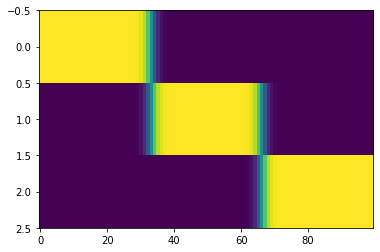

In [12]:
plt.imshow(weight_stack.tag.test_value[1],aspect='auto')

In [13]:
with model:
    selected_lambdas = lambdas[category][:,:,np.newaxis]
print(selected_lambdas.tag.test_value.shape)

(30, 3, 1)


In [14]:
with model:
    lambda_ = tt.sum(selected_lambdas*weight_stack,axis=1)
    #lambda_ = weight_stack[:,0]*lambda0 + weight_stack[:,1]*lambda1 + weight_stack[:,2]*lambda2
    #lambda_ = tt.tensordot(weight_stack, lambdas, [1,0])
    #lambda_ = mixes.dot(weight_stack)
    #lambda_fin = np.tile(lambda_[np.newaxis,:], (data_vec.shape[0],1))
    

In [15]:
print(lambda_.tag.test_value.shape)

(30, 100)


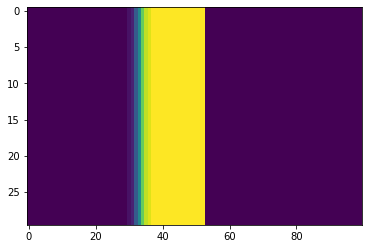

In [16]:
plt.imshow(lambda_.tag.test_value,aspect='auto')

In [17]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

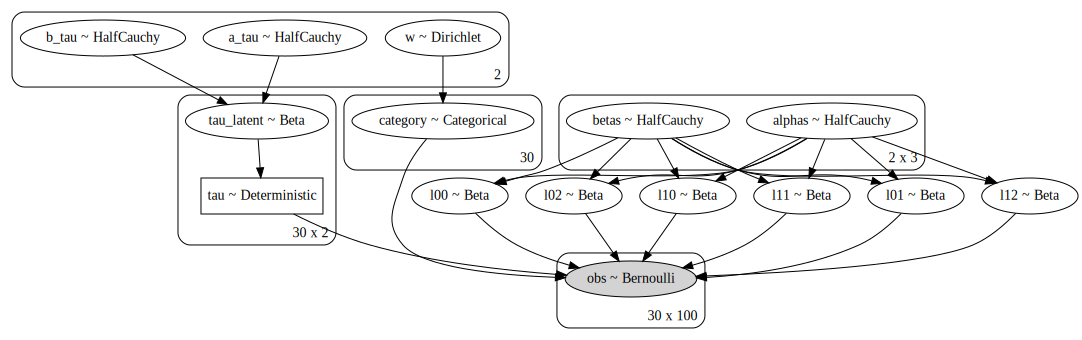

In [18]:
pm.model_to_graphviz(model)

In [20]:
with model:     
    #step = pm.Metropolis()
    step = pm.NUTS()
    trace = pm.sample(step=step)
# with model:
#     inference = pm.ADVI('full-rank')
#     approx = pm.fit(n=fit, method=inference,
#                    random_seed = 3,
#                    obj_n_mc = 1)
#     trace = approx.sample(draws=samples)

/home/abuzarmahmood/anaconda3/envs/pymc3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/envs/pymc3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [tau_latent, b_tau, a_tau, l12, l11, l10, l02, l01, l00, betas, alphas, w]
>BinaryGibbsMetropolis: [cat

In [21]:
#pm.traceplot(trace);

In [22]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)

100%|██████████| 2000/2000 [00:02<00:00, 874.16it/s]


In [23]:
ppc_trace['obs'].shape
mean_ppc_obs = np.mean(ppc_trace['obs'],axis=0)

In [24]:
tau_samples = trace['tau']
int_tau = np.vectorize(np.int)(tau_samples)
print(int_tau.shape)
mode_tau = stats.mode(int_tau,axis=0)[0][0]
print(mode_tau.shape)

(2000, 30, 2)
(30, 2)


In [25]:
hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

(2000, 30)


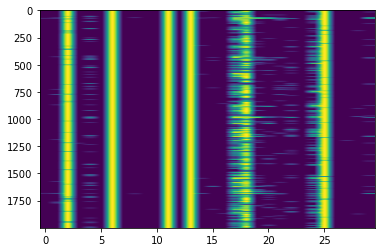

In [26]:
cat_samples = trace['category']
plt.imshow(cat_samples,aspect='auto')
print(cat_samples.shape)

In [27]:
cat_hist = np.array([np.histogram(trial,bins=np.arange(3))[0] for trial in cat_samples.swapaxes(0,1)])
#print(cat_hist)

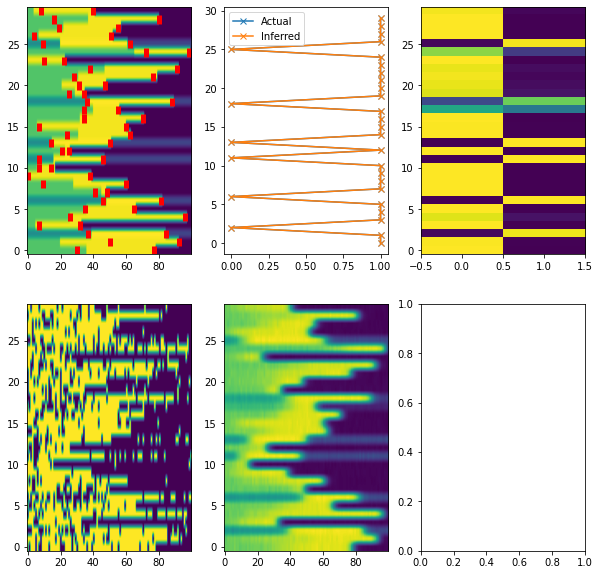

In [28]:
fig,ax = plt.subplots(2,3,figsize=(10,10))
ax[0,1].plot(component_inds, np.arange(trials),'-x',label='Actual')
ax[0,1].plot(np.round(1-np.mean(cat_samples,axis=0)), np.arange(trials),'-x', label='Inferred')
ax[0,1].legend()
for trial,val in enumerate(mode_tau):
    ax[0,0].vlines(val, trial-0.5,trial+0.5, linewidth = 5, color='red')
ax[0,0].imshow(true_r,aspect='auto',origin='lower')
ax[1,0].imshow(data_vec,aspect='auto',origin='lower')
ax[1,1].imshow(mean_ppc_obs,aspect='auto',origin='lower');
ax[0,2].imshow(cat_hist,aspect='auto',origin='lower');
plt.show()